In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import sys

sys.path.append("../")

from src.envs import RLFSEnvSparse
from src.rl import REINFORCE
from src.errors import sammon_error

In [2]:
INF_LOOP_CNT = 5

In [3]:
def get_data_frames(train_path, test_path):
    data_train = pd.read_csv(train_path, sep=",")
    data_test = pd.read_csv(test_path, sep=",")

    return data_train, data_test


def get_data_train_test(data_train, data_test):
    X_train = data_train.drop(columns=["repository"], inplace=False)
    X_train = X_train.to_numpy()

    X_test = data_test.drop(columns=["repository"], inplace=False)
    X_test = X_test.to_numpy()

    return X_train, X_test

def powers_of_two_less_than(n):
    max_exponent = int(np.log2(n))  # Find the largest exponent such that 2^k < N
    return 2 ** np.arange(max_exponent+1)

In [4]:
def train_reinforce_agent(X_train, agent, device, make_plots=False):
    state_space = X_train.shape[1]
    action_space = X_train.shape[1]
    for i, num_features in enumerate(powers_of_two_less_than(state_space//2)):
            env = RLFSEnvSparse(
                state_size=state_space, data=X_train, max_features=num_features
            )
            print(f"Iteration {i}, Number of features {num_features}")
            episode_returns = agent.train(
                env=env,
                num_episodes=500 + 1000 // (i+1),
                max_steps=num_features,
            )
            # torch.save(agent.policy.state_dict(), "models/REINFORCE/policy_weights.pth")
            if make_plots:
                plt.plot(episode_returns)
                plt.show()

In [5]:
def test_agent(X_test, data_test, agent, verbose=True):
    state_space = X_test.shape[1]
    action_space = X_test.shape[1]
    env = RLFSEnvSparse(state_size=state_space, data=X_test, max_features=state_space)
    errors = []
    num_ftrs = []
    selected_features = []
    if verbose:
        print("waiting...")
    for n in range(1, state_space+1):
        state = env.reset()
        # errors.append(sammon_error(X_test, state))
        state_cnt = 0  # int(np.sum(state))
        done = False
        # if verbose:
        #     print(f"n={n}")
        inf_loop_cnt = INF_LOOP_CNT
        action_sequence = []
        while state_cnt < n and not done:
            if inf_loop_cnt > 0:
                action, action_prob = agent.select_action_deterministic(state)
            else:
                # print("+")
                action, action_prob = agent.select_action(state)
                # print(np.exp(action_prob.detach().numpy()))

            next_state, _, done, _ = env.step(action)
            action_sequence.append(action)

            if int(np.sum(next_state)) > state_cnt:
                # print(state_cnt)
                inf_loop_cnt = INF_LOOP_CNT
                state_cnt = int(np.sum(next_state))
            else:
                inf_loop_cnt -= 1

            state = next_state
        # print(np.sum(state))
        error = sammon_error(X_test, state)
        errors.append(error)
        num_ftrs.append(n)
        selected_features.append(
            [data_test.drop(columns=["repository"]).columns[action] for action in action_sequence]
        )

    return errors, num_ftrs, selected_features

In [6]:
train_path_class = "../data/data_class_train.csv"
test_path_class = "../data/data_class.csv"
train_path_method = "../data/data_method_train.csv"
test_path_method = "../data/data_method.csv"

In [7]:
data_train_method, data_test_method = get_data_frames(train_path_method, test_path_method)
X_train_method, X_test_method = get_data_train_test(data_train_method, data_test_method)
state_space_method = X_train_method.shape[1]
action_space_method = X_train_method.shape[1]

data_train_class, data_test_class = get_data_frames(train_path_class, test_path_class)
X_train_class, X_test_class = get_data_train_test(data_train_class, data_test_class)
state_space_class = X_train_class.shape[1]
action_space_class = X_train_class.shape[1]

In [8]:
data_train_method.shape, data_test_method.shape

((53, 27), (106, 27))

In [9]:
data_train_class.shape, data_test_class.shape

((64, 31), (128, 31))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = REINFORCE.REINFORCEAgent(state_space_method, action_space_method, gamma=1, lr=0.0001)

In [11]:
def run_train_test(X_train, X_test, data_test, agent, device):
    train_reinforce_agent(X_train, agent, device)
    return test_agent(X_test, data_test, agent)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
agent_method = REINFORCE.REINFORCEAgent(
    state_space_method, action_space_method, gamma=1, lr=0.0001
)
errors, num_ftrs, selected_features = run_train_test(
    X_train=X_train_method,
    X_test=X_test_method,
    data_test=data_test_method,
    agent=agent_method,
    device=device,
)

print(selected_features)


Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1255.35it/s, LR=0.0001, Return=0.00275]


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1035.40it/s, LR=0.0001, Return=0.351] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 763.46it/s, LR=0.0001, Return=0.317] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 528.60it/s, LR=0.0001, Return=4.25] 


waiting...
[['HEFF'], ['HEFF', 'HVOL'], ['HEFF', 'HVOL', 'MI'], ['HEFF', 'HVOL', 'MI', 'HCPL'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'HPL'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'HPL', 'NOS'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'HPL', 'NOS', 'CLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'HPL', 'NOS', 'CLOC', 'TCLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'HPL', 'NOS', 'CLOC', 'TCLOC', 'TNOS'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'HPL', 'NOS', 'CLOC', 'TCLOC', 'TNOS', 'DLOC'], ['HEFF', 'HVOL', 'MI', 'HCPL', 'H

In [14]:
selected_features_ = []
selected_features_.extend(selected_features[-1])

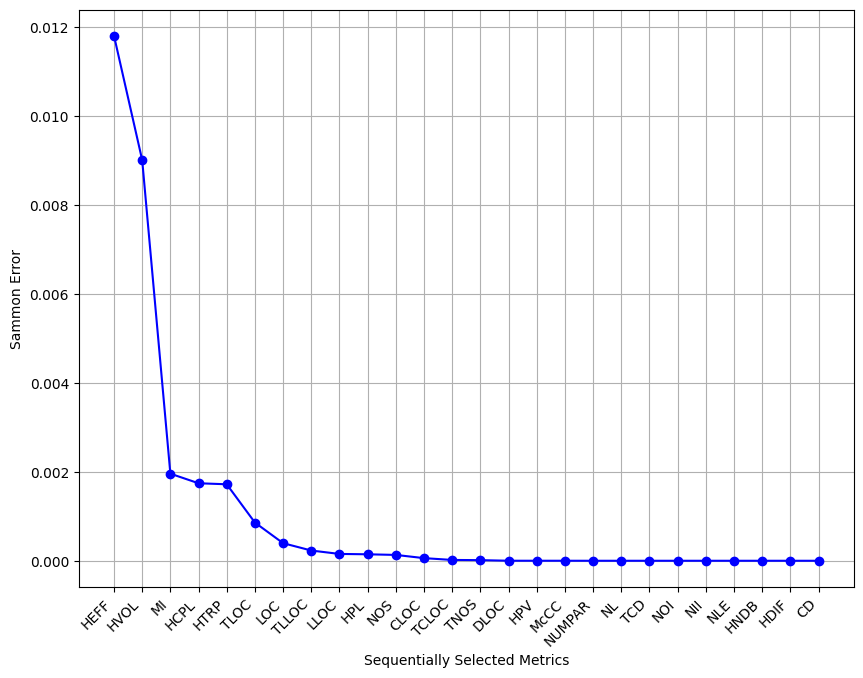

In [15]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [16]:
agent_class = REINFORCE.REINFORCEAgent(
    state_space_class, action_space_class, gamma=1, lr=0.0001
)
errors, num_ftrs, selected_features = run_train_test(
    X_train=X_train_class,
    X_test=X_test_class,
    data_test=data_test_class,
    agent=agent_class,
    device=device,
)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1292.29it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 938.06it/s, LR=0.0001, Return=0.00624]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 727.88it/s, LR=0.0001, Return=0.175]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 457.09it/s, LR=0.0001, Return=0.491]


waiting...


In [20]:
selected_features_ = []
selected_features_.extend(selected_features[-1])

In [21]:
print(selected_features_)

['LOC', 'TLOC', 'LLOC', 'TLLOC', 'TNOS', 'NOS', 'CLOC', 'WMC', 'TNM', 'NM', 'RFC', 'TNLM', 'NLM', 'NOI', 'LCOM5', 'TNA', 'NLE', 'NLA', 'CD', 'NOC', 'NOA', 'CBO', 'CBOI', 'NII', 'NOD', 'NA', 'TNLA', 'DIT', 'NOP', 'NL']


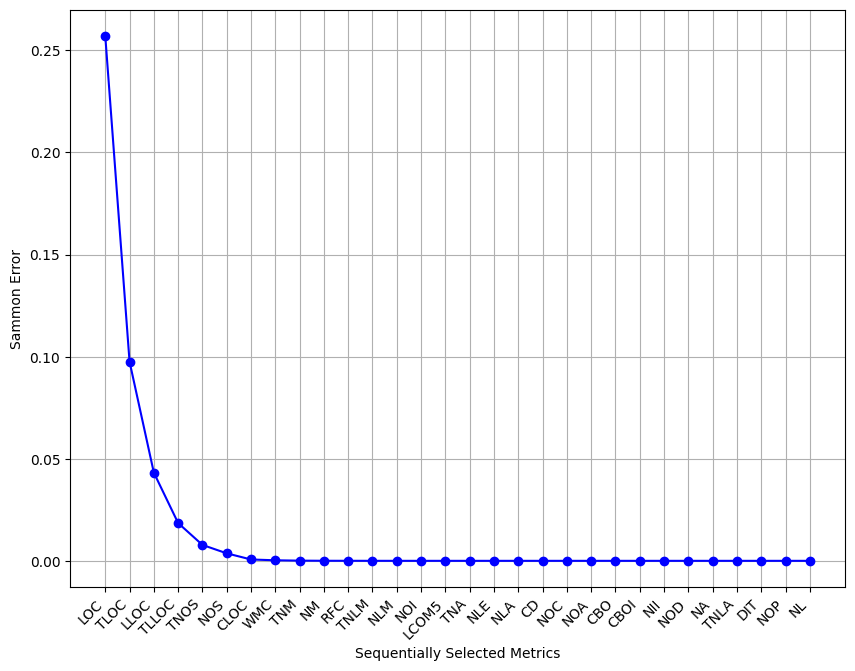

In [22]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [23]:
def test_stability(X_train, X_test, data_test, num_iters=10):
    state_space = X_train.shape[1]
    action_space = X_train.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_errors = []
    all_num_ftrs = []
    all_selected_features = []
    for i in range(num_iters):
        agent = REINFORCE.REINFORCEAgent(state_space, action_space, gamma=1, lr=0.0001)
        errors, num_ftrs, selected_features = run_train_test(
            X_train, X_test, data_test, agent, device
        )
        all_errors.append(errors)
        all_num_ftrs.append(num_ftrs)
        all_selected_features.append(selected_features)

    return all_errors, all_num_ftrs, all_selected_features

In [24]:
all_errors, all_num_ftrs, all_selected_features = test_stability(X_train_class, X_test_class, data_test_class, num_iters=10)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1218.91it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 977.05it/s, LR=0.0001, Return=1.35]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 703.60it/s, LR=0.0001, Return=0.00833]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 513.25it/s, LR=0.0001, Return=0.442] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1276.01it/s, LR=0.0001, Return=0.00624]


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1001.61it/s, LR=0.0001, Return=-1e-5] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 763.54it/s, LR=0.0001, Return=0.287]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 516.35it/s, LR=0.0001, Return=1.94] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1266.90it/s, LR=0.0001, Return=0.00416]


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 951.50it/s, LR=0.0001, Return=0.461]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 745.24it/s, LR=0.0001, Return=0.991]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 499.28it/s, LR=0.0001, Return=2.23]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1286.64it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1032.09it/s, LR=0.0001, Return=0.287] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 765.99it/s, LR=0.0001, Return=1.53]   


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 518.49it/s, LR=0.0001, Return=1.86] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1281.21it/s, LR=0.0001, Return=0.438]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1029.43it/s, LR=0.0001, Return=1.01]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 762.14it/s, LR=0.0001, Return=0.463]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 516.08it/s, LR=0.0001, Return=1.79] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1270.18it/s, LR=0.0001, Return=0.00575]


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1031.38it/s, LR=0.0001, Return=0.438] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 749.91it/s, LR=0.0001, Return=0.437]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 511.54it/s, LR=0.0001, Return=2.02] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1065.15it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 947.38it/s, LR=0.0001, Return=0.998]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 750.87it/s, LR=0.0001, Return=1.6]    


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 494.98it/s, LR=0.0001, Return=2.72]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1275.26it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 938.76it/s, LR=0.0001, Return=0.00438]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 759.64it/s, LR=0.0001, Return=0.462]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 515.35it/s, LR=0.0001, Return=2.54] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1265.91it/s, LR=0.0001, Return=0.287]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1019.77it/s, LR=0.0001, Return=0.996] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 758.62it/s, LR=0.0001, Return=0.438]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 485.60it/s, LR=0.0001, Return=0.349] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1208.65it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1014.04it/s, LR=0.0001, Return=0.0853]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 763.10it/s, LR=0.0001, Return=0.997]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 510.46it/s, LR=0.0001, Return=2.71] 


waiting...


In [27]:
min_errors = np.min(all_errors, axis=0)
max_errors = np.max(all_errors, axis=0)
avg_errors = np.mean(all_errors, axis=0)
min_errors, max_errors, avg_errors

(array([2.57124478e-01, 9.75449645e-02, 4.31939462e-02, 1.85016886e-02,
        7.79003105e-03, 3.19280335e-03, 6.63314552e-04, 2.65971245e-04,
        9.46305014e-05, 3.24146997e-05, 1.60601882e-05, 6.02744665e-06,
        1.14528182e-06, 5.72780123e-08, 3.72281631e-08, 3.72281631e-08,
        2.40655874e-08, 1.74403051e-08, 1.24886050e-08, 6.66737369e-09,
        6.66737369e-09, 6.66737369e-09, 6.66737369e-09, 5.91032200e-10,
        1.99403505e-20, 1.99403505e-20, 1.99403505e-20, 1.99403505e-20,
        1.99403505e-20, 1.99403505e-20]),
 array([3.63028417e-01, 1.95966715e-01, 1.01541305e-01, 4.50792091e-02,
        1.79793631e-02, 3.67713718e-03, 6.63314552e-04, 2.65971245e-04,
        2.28740552e-04, 7.23670215e-05, 5.39062641e-05, 4.21618087e-05,
        2.60750098e-06, 1.14528182e-06, 1.11008391e-06, 1.10893861e-06,
        1.10893861e-06, 1.10893861e-06, 4.72225426e-08, 4.03805746e-08,
        3.77826500e-08, 2.40655874e-08, 2.40655874e-08, 2.40655874e-08,
        1.38624526e-08

In [28]:
df_reinforce_class = pd.DataFrame({
    "number_of_features": all_num_ftrs[0],
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_reinforce_class

,number_of_features,min_error,max_error,avg_error
0,1,2.571245e-01,3.630284e-01,3.205028e-01
1,2,9.754496e-02,1.959667e-01,1.473565e-01
2,3,4.319395e-02,1.015413e-01,6.316790e-02
3,4,1.850169e-02,4.507921e-02,2.885782e-02
4,5,7.790031e-03,1.797936e-02,8.813843e-03
5,6,3.192803e-03,3.677137e-03,3.580276e-03
6,7,6.633146e-04,6.633146e-04,6.633146e-04
7,8,2.659712e-04,2.659712e-04,2.659712e-04
8,9,9.463050e-05,2.287406e-04,1.094388e-04
9,10,3.241470e-05,7.236702e-05,4.018512e-05


In [29]:
df_reinforce_class.to_csv("../data/results/REINFORCE_class.csv", index=False)

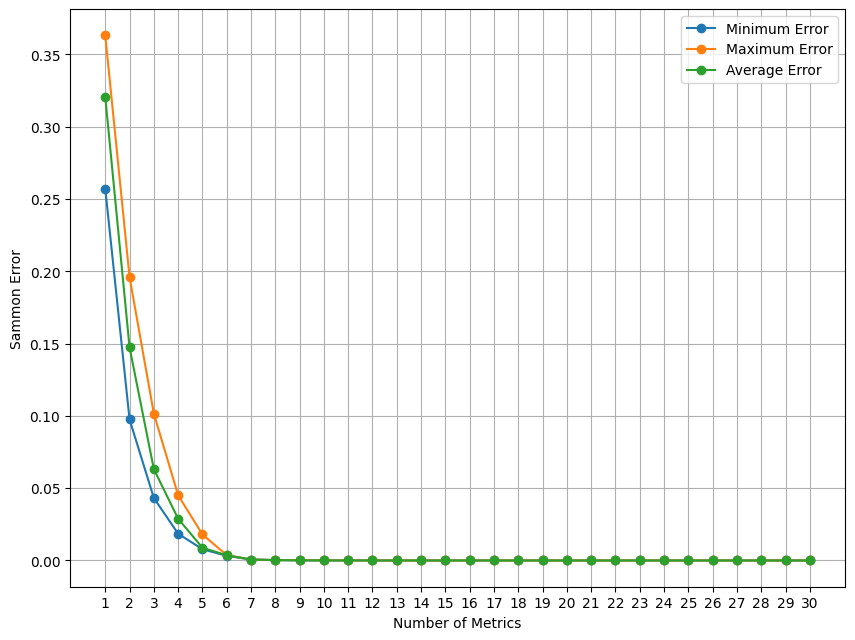

In [30]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(all_num_ftrs[0], min_errors, marker='o', label='Minimum Error')
plt.plot(all_num_ftrs[0], max_errors, marker='o', label='Maximum Error')
plt.plot(all_num_ftrs[0], avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(all_num_ftrs[0])  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()

In [31]:
all_errors_m, all_num_ftrs_m, all_selected_features_m = test_stability(X_train_method, X_test_method, data_test_method, num_iters=10)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1227.77it/s, LR=0.0001, Return=0.0402] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1010.76it/s, LR=0.0001, Return=0.369] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 772.31it/s, LR=0.0001, Return=0.085]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 524.77it/s, LR=0.0001, Return=0.321] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1284.18it/s, LR=0.0001, Return=-1e-5]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1005.35it/s, LR=0.0001, Return=0.109] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 770.11it/s, LR=0.0001, Return=0.519] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 527.01it/s, LR=0.0001, Return=0.402] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1272.59it/s, LR=0.0001, Return=0.0726] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1029.02it/s, LR=0.0001, Return=0.154] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 756.21it/s, LR=0.0001, Return=0.216]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 515.55it/s, LR=0.0001, Return=0.328] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1287.45it/s, LR=0.0001, Return=0.106]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1030.74it/s, LR=0.0001, Return=4.1]   


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 766.42it/s, LR=0.0001, Return=0.154]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 523.33it/s, LR=0.0001, Return=6.08]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1217.13it/s, LR=0.0001, Return=0.254]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1026.21it/s, LR=0.0001, Return=0.013] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 772.46it/s, LR=0.0001, Return=0.345] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 517.36it/s, LR=0.0001, Return=0.39] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1148.87it/s, LR=0.0001, Return=0.109]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 971.01it/s, LR=0.0001, Return=0.121]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 720.61it/s, LR=0.0001, Return=0.51]   


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 534.25it/s, LR=0.0001, Return=4.23] 


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1299.83it/s, LR=0.0001, Return=0.0445] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1030.89it/s, LR=0.0001, Return=3.86]  


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 768.24it/s, LR=0.0001, Return=0.189] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 533.86it/s, LR=0.0001, Return=4.52]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1247.92it/s, LR=0.0001, Return=0.154]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 983.71it/s, LR=0.0001, Return=4.11]   


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 756.12it/s, LR=0.0001, Return=0.263] 


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 523.07it/s, LR=0.0001, Return=6.09]  


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1252.41it/s, LR=0.0001, Return=0.109]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 1008.57it/s, LR=0.0001, Return=0.172] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 760.30it/s, LR=0.0001, Return=0.178]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 515.65it/s, LR=0.0001, Return=0.391]


waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1286.69it/s, LR=0.0001, Return=0.0143] 


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 948.89it/s, LR=0.0001, Return=0.28]   


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 733.22it/s, LR=0.0001, Return=0.336]  


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 473.02it/s, LR=0.0001, Return=0.552] 


waiting...


In [33]:
print(all_selected_features[0][-1])
print([float(error) for error in all_errors[0]])

['TLOC', 'LOC', 'TLLOC', 'TNOS', 'NOS', 'LLOC', 'CLOC', 'WMC', 'TNM', 'NM', 'RFC', 'TNLM', 'NLM', 'NOC', 'NOI', 'NOA', 'LCOM5', 'TNLA', 'NLE', 'NOP', 'CBO', 'NII', 'TNA', 'DIT', 'NOD', 'NL', 'CBOI', 'NA', 'CD', 'NLA']
[0.25777669026353045, 0.09754496447066958, 0.043274685773930927, 0.026608856429451974, 0.017979363121562234, 0.0036771371790677654, 0.000663314552224087, 0.0002659712453194879, 9.463050136472389e-05, 3.2414699660032376e-05, 1.6060188221672594e-05, 6.027446646989955e-06, 1.1452818178649029e-06, 1.1240297545258297e-06, 1.0820920866044532e-06, 1.048956335862148e-06, 2.406558743572561e-08, 2.406558743572561e-08, 2.406558743572561e-08, 1.7742196274142174e-08, 6.667373686160637e-09, 6.667373686160637e-09, 6.667373686160637e-09, 1.7402795168636465e-09, 1.99403504986271e-20, 1.99403504986271e-20, 1.99403504986271e-20, 1.99403504986271e-20, 1.99403504986271e-20, 1.99403504986271e-20]


In [34]:
print(all_selected_features_m[0][-1])
print([float(error) for error in all_errors_m[0]])

['HEFF', 'HVOL', 'MI', 'HCPL', 'HTRP', 'TLOC', 'LOC', 'TLLOC', 'LLOC', 'TCLOC', 'CLOC', 'HPL', 'HPV', 'NOS', 'DLOC', 'TNOS', 'NUMPAR', 'TCD', 'HDIF', 'McCC', 'NOI', 'NLE', 'HNDB', 'NII', 'CD', 'NL']
[0.011813886698870594, 0.009016885786702365, 0.0019596797875874477, 0.0017440825400036667, 0.0017211518924381128, 0.0008596289643286363, 0.0003956875744888608, 0.00023038280405010263, 0.00015375953289815947, 7.57908739482448e-05, 2.994428469888183e-05, 2.538607389058575e-05, 2.3636988791089767e-05, 1.717158682412857e-05, 2.1426329486605228e-06, 5.155867740509122e-07, 7.214705722190872e-08, 7.214705722190872e-08, 7.071032594777901e-08, 1.412502739585417e-10, 4.170330986079913e-18, 4.170330986079913e-18, 1.3786943288452742e-20, 1.3786943288452742e-20, 1.3786943288452742e-20, 1.3786943288452742e-20]


In [35]:
min_errors = np.min(all_errors_m, axis=0)
max_errors = np.max(all_errors_m, axis=0)
avg_errors = np.mean(all_errors_m, axis=0)
min_errors, max_errors, avg_errors

(array([1.18138867e-02, 9.01688579e-03, 1.95967979e-03, 1.74408254e-03,
        8.77128985e-04, 4.08456459e-04, 2.40667091e-04, 2.30382804e-04,
        1.53759533e-04, 7.57908739e-05, 2.99442847e-05, 2.48426575e-05,
        7.00018890e-06, 2.72230053e-06, 8.38472757e-07, 5.15586774e-07,
        7.21470572e-08, 3.00812035e-10, 9.43547399e-11, 4.17033099e-18,
        4.17033099e-18, 1.37869433e-20, 1.37869433e-20, 1.37869433e-20,
        1.37869433e-20, 1.37869433e-20]),
 array([1.18138867e-02, 9.01688579e-03, 1.95967979e-03, 1.92779415e-03,
        1.72115189e-03, 8.63930090e-04, 5.62495463e-04, 2.30382804e-04,
        2.19342626e-04, 1.49504584e-04, 1.31399976e-04, 1.28218164e-04,
        5.70247389e-05, 4.94752427e-05, 1.21389888e-05, 6.77832352e-07,
        5.15586217e-07, 5.11966894e-07, 5.11966894e-07, 5.11966894e-07,
        5.11966894e-07, 4.04821392e-07, 4.04821392e-07, 4.01281769e-07,
        9.43296131e-11, 1.37869433e-20]),
 array([1.18138867e-02, 9.01688579e-03, 1.95967979e-

In [36]:
df_reinforce_method = pd.DataFrame({
    "number_of_features": all_num_ftrs_m[0],
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_reinforce_method

,number_of_features,min_error,max_error,avg_error
0,1,1.181389e-02,1.181389e-02,1.181389e-02
1,2,9.016886e-03,9.016886e-03,9.016886e-03
2,3,1.959680e-03,1.959680e-03,1.959680e-03
3,4,1.744083e-03,1.927794e-03,1.762454e-03
4,5,8.771290e-04,1.721152e-03,1.216046e-03
5,6,4.084565e-04,8.639301e-04,7.259977e-04
6,7,2.406671e-04,5.624955e-04,4.134960e-04
7,8,2.303828e-04,2.303828e-04,2.303828e-04
8,9,1.537595e-04,2.193426e-04,1.668762e-04
9,10,7.579087e-05,1.495046e-04,1.378520e-04


In [37]:
df_reinforce_method.to_csv("../data/results/REINFORCE_method.csv", index=False)

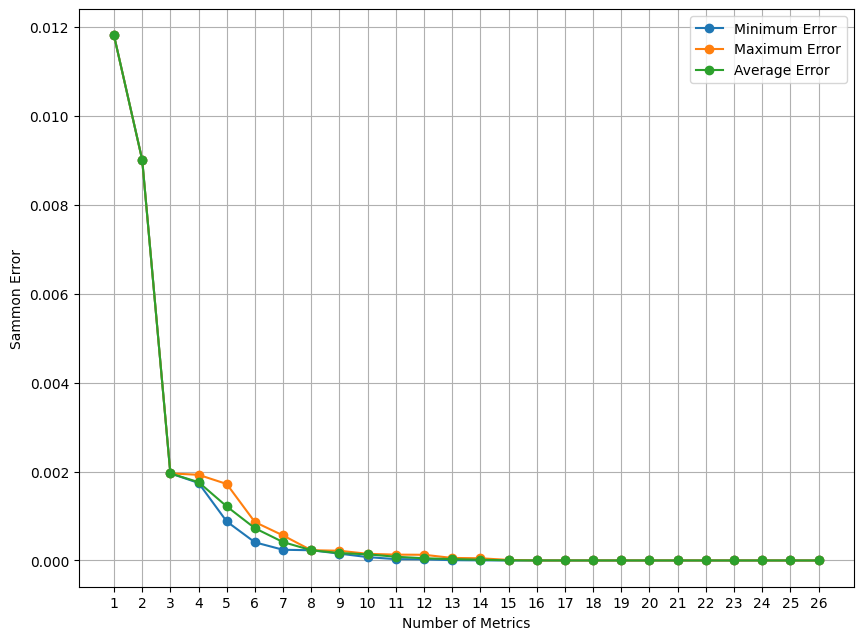

In [38]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(all_num_ftrs_m[0], min_errors, marker='o', label='Minimum Error')
plt.plot(all_num_ftrs_m[0], max_errors, marker='o', label='Maximum Error')
plt.plot(all_num_ftrs_m[0], avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(all_num_ftrs_m[0])  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()